## **Varied Intertrial Intervals Tutorial**

Another key consideration in fMRI experiments is allowing for different intertrial intervals (ITI) between certain stimuli. The base Neurodesign package allows the user to input one ITI, which is then used between all stimuli.

This modificaiton allows you to add custom ITI for each pair of stimuli, representing the ITI distribution the occurs when a specific pairing of stimuli occurs in the order.

* **`conditional_iti`** `(dict)`
    * Adds a new input of ITI that can be calculated from the chosen probability distribution of the users. This variable holds the information about the probability distribution for an ITI between two specific stimuli.
    * There is also a `'default'` key used if a relationship between two specific ITI in order is not provided.
    * **Example Structure:**
        ```python
        self.conditional_ITI = {
            (0, 1): {"model": "exponential", "mean": 2, "min": 1},
            (1, 2): {"model": "fixed", "mean": 4},
            "default": {"model": "exponential", "mean": 3, "min": 1}
        }
        ```

**With conditional_ITI, we need a function the can read the dictionary and generate the current ITI based on the dictionary**

* **`generate_iti(self, order, conditional_iti)`**
    * Generates ITI with the first value using the `'default'` entry, then appended relative to distributions of stimuli in order.
    * Ensures `n_trials` and ITI length are the same.

### **Example**

For the following example, we will use the following conditional_iti:

```python
observe_conditional_iti = {
    (0, 1): {"model": "uniform", "mean": 2.5, "min": 1, "max": 4}, 
    (2, 3): {"model": "exponential", "mean": 2.5, "min": 1, "max": 4}, 
    "default": {"model": "exponential", "mean": 2, "min": 1, "max": 4} 
}
```

**What does this tell us about the relationships?**

In the order, when we have the following two stimuli adjacent to each other: 

1. [0,1] then it will use the uniform distibution

2. [2,3] then it will use the exponential distribution with mean 2.5

3. else for all other pairings ([1,0], [3,2], [0,2], [0,3], etc.), it will us the default mapping

**Note: When using conditional_ITI, you MUST define the ITI_max to be the highest possible ITI in all the distributions**

In [1]:
import numpy as np
import neurodesign
import matplotlib.pyplot as plt

In [2]:
import os
# Since Neurodesign uses multi-threading internally, limit the number of threads
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [3]:
conditional_iti = {
    (0, 1): {"model": "uniform", "mean": 7, "min": 1, "max": 8}, #1, 4
    (2, 3): {"model": "exponential", "mean": 10, "min": 1, "max": 15}, #1, 4
    "default": {"model": "exponential", "mean": 2, "min": 1, "max": 4} #1, 4
}

In [4]:
exp = neurodesign.Experiment(
    TR=2,                        # Repetition time (TR) of fMRI acquisition in seconds
    n_trials=20,                 # Number of trials (short toy example)
    P=[0.25, 0.25, 0.25, 0.25],           # Condition probabilities: Condition 2 is slightly overrepresented
    C=[[1,0, -1, 0],[1, 0, 0, -1], [0, 1, -1, 0],  [0, 1, 0,-1]],  # Contrasts: C1 vs C3, C1 vs C4
    n_stimuli=4,                 # Total number of stimulus conditions
    rho=0.3,                     # Temporal autocorrelation in fMRI noise
    stim_duration=1,            # Duration of each stimulus (in seconds)
    t_pre=1,                  # Pre-stimulus baseline (e.g., fixation)
    t_post=0.5,                   # Post-stimulus period (e.g., feedback)
    ITImodel="exponential",     # Inter-trial interval (ITI) sampling model
    ITImin=1,                   # Minimum ITI
    ITImax=15,                   # Maximum ITI
    ITImean=2.5,                # Mean ITI
    conditional_ITI = conditional_iti,
)

/Users/atharvumap/Documents/Projects/neurodesign_plus/.venv/lib/python3.13/site-packages/neurodesign/classes.py:639: UserWarning: the resolution is adjusted to be a multiple of the TR. New resolution: 0.1
  warnings.warn(
/Users/atharvumap/Documents/Projects/neurodesign_plus/.venv/lib/python3.13/site-packages/neurodesign/classes.py:821: RuntimeWarning: divide by zero encountered in log
  res = (h - 1) * np.log(s) + h * np.log(l) - l * s - np.log(gamma(h))


In [5]:
population = neurodesign.Optimisation(
    experiment=exp,
    R=[1, 0, 0], # 100% blocked, 0% random, 0% msequence
    weights=[0, 0.5, 0.25, 0.25],  # Weights for Fe, Fd, confounding, and frequency
    preruncycles=10,               # Warm-up iterations
    cycles=100,                    # Main genetic algorithm iterations
    folder="./",                   # Output folder for results
    seed=100                       # Seed for reproducibility
)

population.optimise()             # Run the optimization

/Users/atharvumap/Documents/Projects/neurodesign_plus/.venv/lib/python3.13/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [6]:
best_design = population.bestdesign  # The best subject from the final generation

print(f"Fd (detection efficiency): {best_design.Fd}")
print(f"Ff (estimation efficiency): {best_design.Ff}")
print(f"Fc (confounding): {best_design.Fc}")
print(f"Fe (stimulus frequency balance): {best_design.Fe}")

Fd (detection efficiency): 0.8464233847515515
Ff (estimation efficiency): 1.0
Fc (confounding): 0.7479954180985109
Fe (stimulus frequency balance): 0


[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 9.09093612e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 8.47105211e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.04073059e-01  2.78856076e-05  0.00000000e+00  0.00000000e+00]
 [ 1.71554158e-01  4.82662401e-02  0.00000000e+00  0.00000000e+00]
 [ 8.59319272e-02  1.87871688e-01  0.00000000e+00  0.00000000e+00]
 [ 2.55981307e-02  1.90041761e-01  7.05554114e-05  0.00000000e+00]
 [-5.13426811e-03  1.06224353e-01  5.49730130e-02  0.00000000e+00]
 [-1.71045078e-02  3.74957617e-02  1.92051320e-01  8.93409566e-06]
 [-1.81472623e-02  4.05126466e-04  1.86681821e-01  4.19453804e-02]
 [-1.40373385e-02 -1.53927436e-02  1.02028309e-01  1.83234327e-01]
 [-8.92070859e-03 -1.85720736e-02  3.49562776e-02  1.93193102e-01]
 [-4.88596867e-03 -1.52870260e-02 -8.01970778e-04  1.11388617e-01]
 [-2.37251333e-03 -1.01455578e-02 -1.57939537e-02  1.24828557e-01]
 [-1.04173036e-03 -5.74927298e-03 -1.85161780e-02  2.10260874e

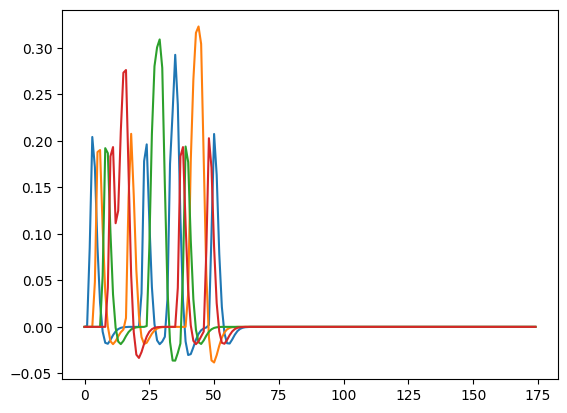

In [7]:
# Compute the convolved bestdesign matrix and evaluate design quality
best_design.designmatrix()
print(best_design.Xconv)
plt.plot(best_design.Xconv)

**There is a lot of empty space offset, why is this?** Since we give a range of ITI along with distributions, the model uses the maximum possible ITI to calculate the timepoints.

Then, it maps the real values onto the graph, ensuring any randomized mapping of timepoints will fit on the graph. An easy way to clean this is simply bounding the x-axis on the plot.

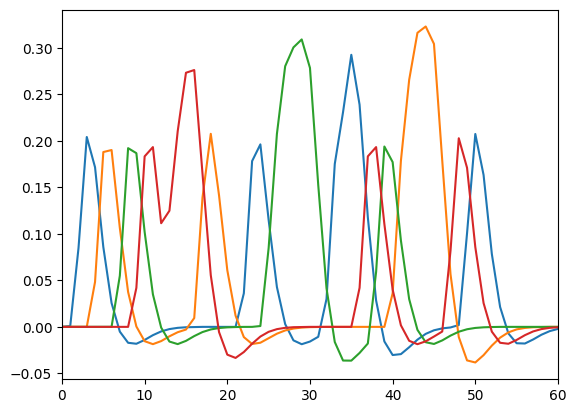

In [8]:
plt.xlim(0,60)
plt.plot(best_design.Xconv)

#### **Observations**
1. Notice that the peaks are now all of different size, this is because of the varied ITI. The higher the ITI, the higher the peak displayed on the diagram as the set of timepoints considers both the stimuli_duration and the ITI. 

2. Each stimuli's peak begins when the previous one reaches its peak, but notice how with higher ITI and higher peaks, the stimuli takes more of the x-axis, reflecting different ITI as desired.